In [2]:
import qutip, pickle, sys
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import time as time
import math, cmath
import auxiliary_library as me

from IPython.display import display, Math, Latex
np.set_printoptions(threshold=1.e-9,linewidth=120,precision=3, suppress=True, formatter={"float":lambda x: str(.001*int(1000*x))})

In [4]:
N=3; chain_type = "XYZ"; k_B = 1; temp = 1e2; temp_ref = 1e0

### Construcción de los operadores
spin_ops_list = me.one_body_spin_ops(N)
identity_op = spin_ops_list[0][0]
ts = np.linspace(0, 50,700)  

### Heisenberg Hamiltonian
Hamiltonian_paras = [.2, .15, .1, 1.]
H_H = me.Heisenberg_Hamiltonian(op_list = spin_ops_list, chain_type = chain_type,
                                size = N, Hamiltonian_paras = Hamiltonian_paras,
                                closed_bcs = True, visualization = False)
### classical operators 

cl_ops, label_ops = me.classical_ops(H_H, N, spin_ops_list, False)
magnetization = sum(spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))
neel_operator = sum((-1)**a * spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))

cl_ops["magnetization"] = magnetization; label_ops.append("magnetization")
cl_ops["neel_op"] = neel_operator; label_ops.append("neel_op")
print("Are all the operators Hermitian?:", me.basis_hermitian_check(cl_ops))

Are all the operators Hermitian?: [True, True, True, True, True, True, True, True, True, True]


using a base of size  13
rho_ref:  Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[0.47100000000000003 0.0 0.0 ... 0.024 0.004 0.0]
 [0.0 0.41000000000000003 0.039 ... 0.0 0.0 0.003]
 [0.0 0.039 0.028 ... 0.0 0.0 0.001]
 ...
 [0.024 0.0 0.0 ... 0.026000000000000002 0.002 0.0]
 [0.004 0.0 0.0 ... 0.002 0.0 0.0]
 [0.0 0.003 0.001 ... 0.0 0.0 0.0]]
The basis is orthonormal and hermitian
rho_0:  Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[0.195+0.j    0.   +0.j    0.   +0.j    ... 0.009+0.014j 0.   -0.j    0.   +0.j   ]
 [0.   +0.j    0.214+0.j    0.008+0.018j ... 0.   +0.j    0.   +0.j    0.002-0.001j]
 [0.   +0.j    0.008-0.018j 0.31 +0.j    ... 0.   +0.j    0.   +0.j    0.025+0.012j]
 ...
 [0.009-0.014j 0.   +0.j    0.   +0.j    ... 0.018+0.j    0.002-0.001j 0.   +0.j   ]
 [0.   +0.j    0.   +0.j    0.   +0.j    ... 0.002+0.001j 0.009+0.j    0.   +0.j   ]
 [0.   +0.j    0.

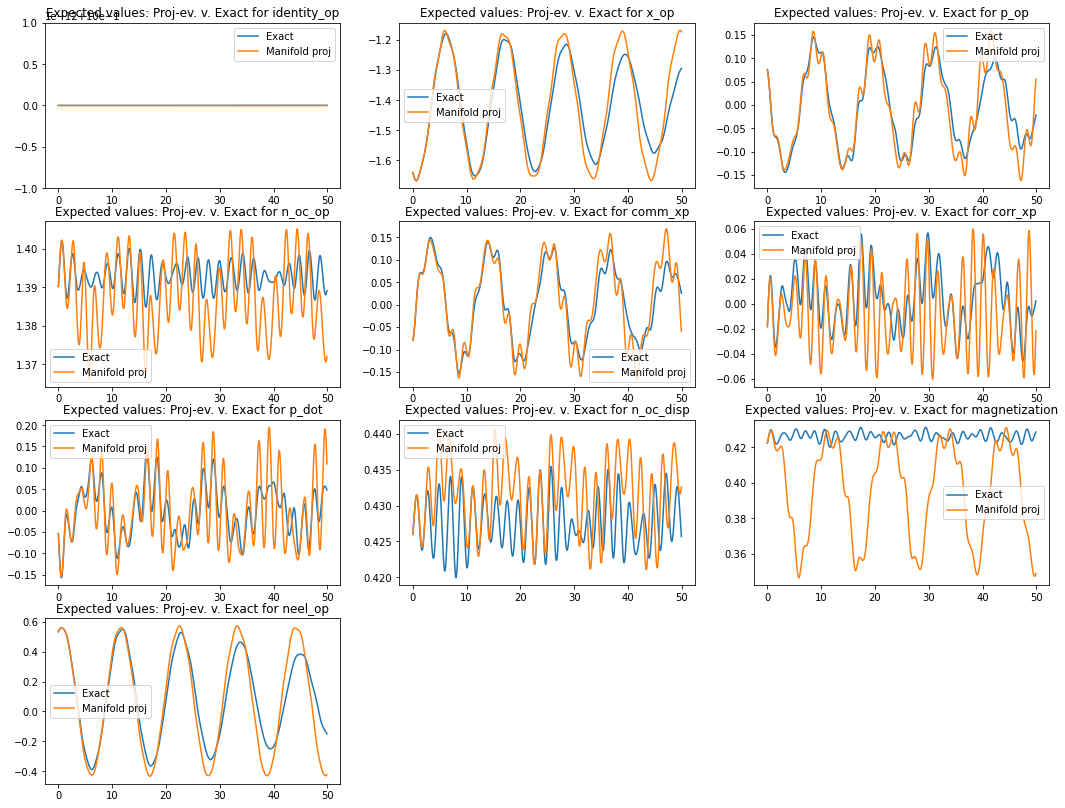

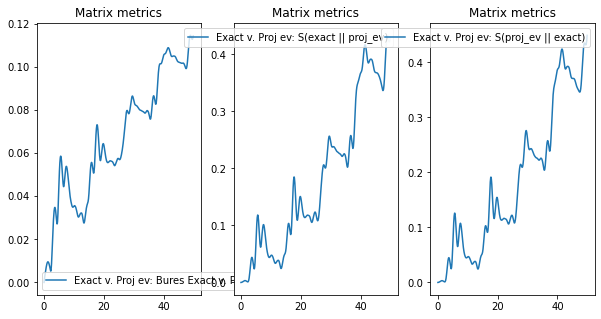

In [17]:
depth_and_seed_ops = [(1, cl_ops["identity_op"]), 
                      (1, H_H), 
                      (11, cl_ops["x_op"])]
coeff_list = [0., .5, .5, .25, .25, .125, .125, .057, .057, .057, .057,.057, .057]

observables = list(cl_ops.values())
Gram_matrix, rho0, dict_res_proj_ev, res_exact, basis_orth = me.d_depth_proj_ev(
    temp_ref = temp_ref, temp_rho = temp, timespan = ts, 
    Hamiltonian = H_H, lagrange_op = cl_ops["n_oc_disp"],
    depth_and_seed_ops = depth_and_seed_ops, observables = observables, 
    label_ops = label_ops, coeff_list = coeff_list, 
    visualize_H_evs = False, visualization_nonherm = False, visualize_expt_vals = True
)